<a href="https://colab.research.google.com/github/EtzionR/LM4GeoAI/blob/main/Geo_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.7 MB/s eta 0:00:00


In [2]:
from pandas.errors import SettingWithCopyWarning
from time import time as get_time
from transformers import pipeline
from shapely import Point
from tqdm import tqdm

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import warnings
import folium

In [3]:
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [24]:
WGS84_UTM_31N = "EPSG:32631"
WGS84_GEO_DD  = "EPSG:4326"

In [4]:
FOOD = {'restaurant','fast_food','cafe'}
FOOD

{'cafe', 'fast_food', 'restaurant'}

### Eiffel Tower Location
WGS84 GEO DD X = 2.2944492, Y = 48.8583088

WGS84 GEO UTM 31N X = 448248, Y = 5411944

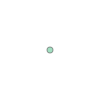

In [12]:
EIFFEL = Point(448248, 5411944)
EIFFEL

In [13]:

eiffecl_wgs84_dd = gpd.GeoSeries([EIFFEL], crs=WGS84_UTM_31N).to_crs(WGS84_GEO_DD).iloc[0]

eiffel_x, eiffel_y = eiffecl_wgs84_dd.x, eiffecl_wgs84_dd.y

fmap = folium.Map(location=[eiffel_y,eiffel_x], zoom_start=15, width=1500, height=500)
folium.Marker([eiffel_y,eiffel_x], popup="Tour Eiffel", tooltip="Tour Eiffel").add_to(fmap)
fmap

In [5]:
place = "Paris, France"

tags = {"amenity": True}

In [6]:
START = get_time()

pois = ox.features_from_place(place, tags)

END = get_time()

In [7]:
pois = pois[['name', 'amenity', 'geometry']].dropna().rename(columns={'amenity':'place_type'}).to_crs(WGS84_UTM_31N)
pois['IsFood'] = pois.place_type.apply(lambda value: value in FOOD)

print(f'Time to extarct data from OSM: {round(END-START,1)} seconds ({round((END-START)/60,1)} minutes)\n\n')

pois.shape

Time to extarct data from OSM: 110.2 seconds (1.8 minutes)




(26500, 4)

In [8]:
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  
element id                                                
node    21662099  POINT (452320.712 5411188.723)   False  
        24910582  POINT (445834.511 5412487.964)   False  
        25213384  POINT (446146.834 5409337.476)   False  
        25214653  POINT (453864.466 5414327.112)   False  
        27415802  POINT (448842.707 5414715.887)   False

In [9]:
is_food_rate = round(pois.IsFood.mean()*100,1)

print(f'{is_food_rate}% of POIs place_type are "Food related" (place_type = {FOOD})')


52.5% of POIs place_type are "Food related" (place_type = {'cafe', 'fast_food', 'restaurant'})


In [10]:
pois.place_type.value_counts().head(10)

,count
place_type,
restaurant,8757
fast_food,2754
cafe,2409
bar,1800
school,1234
bicycle_rental,1052
bank,912
pharmacy,874
social_facility,461


In [14]:
pois['distance_from_eiffel'] = pois.geometry.distance(EIFFEL).round(2)
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  distance_from_eiffel  
element id                                                                      
node    21662099  POINT (452320.712 5411188.723)   False               4142.15  
        24910582  POINT (445834.511 5412487.964)   False               2474.03  
        25213384  POINT (446146.834 5409337.476)   False               3347.96  
        25214653  POINT (453864.466 5414327.112)   False               6101.14  
        27415802  POINT (448842.707 5414715.887)   False               2834.97

In [54]:
top_k = 100

eiffel_radius = pois.sort_values('distance_from_eiffel').iloc[:top_k]

max_distance = eiffel_radius.distance_from_eiffel.round(1).iloc[-1]

print(f'The farthest entity from Eiffel Tower is in distance of {max_distance} meters\n')

eiffel_radius.shape



The farthest entity from Eiffel Tower is in distance of 540.7 meters



(100, 5)

In [42]:
is_food_rate_eiffel = round(eiffel_radius.IsFood.mean()*100,1)

print(f'{is_food_rate_eiffel}% of POIs place_type are "Food related" (place_type = {FOOD})\n\n[Only for the closest {top_k} entities to Eiffel Tower]')


49.0% of POIs place_type are "Food related" (place_type = {'cafe', 'fast_food', 'restaurant'})

[Only for the closest 100 entities to Eiffel Tower]


In [50]:
locations = eiffel_radius.geometry.to_crs(WGS84_GEO_DD).apply(lambda geometry: geometry if geometry.geom_type=='Point' else geometry.centroid)

fmap = folium.Map(location=[eiffel_y,eiffel_x], zoom_start=16, width=1500, height=500)

for location, name in zip(locations, eiffel_radius.name):
    folium.Marker([location.y ,location.x],
                  tooltip=name,
                  zIndexOffset=-1,
                  icon=folium.Icon(color='green', icon='flag')).add_to(fmap)

folium.Marker([eiffel_y,eiffel_x],
              tooltip="Tour Eiffel",
              icon=folium.Icon(color='blue',
                               icon='star-empty'),
              zIndexOffset=100).add_to(fmap)

fmap

In [11]:
MODEL = "intfloat/multilingual-e5-large"

TEXT = "restaurant"

embedder = pipeline("feature-extraction", model=MODEL)

get_text_embedding = lambda text: np.array(embedder(text)[0]).max(0)

get_text_embedding(TEXT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cpu


array([ 1.23215318,  0.75919527, -0.22321977, ..., -0.21436638,
       -0.85060573,  1.06850529])

In [55]:
eiffel_radius['repr'] = [get_text_embedding(text) for text in tqdm(eiffel_radius.name)]

eiffel_radius.head()

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


name       place_type  \
element id                                                 
way     308145239      Madame Brasserie       restaurant   
node    3135278479       Le Jules Verne       restaurant   
        3134285384    Paris Tour Eiffel      post_office   
        12801046288  Snacks Et Boissons        fast_food   
        3134287595     Caisse à billets  vending_machine   

                                                              geometry  \
element id                                                               
way     308145239    POLYGON ((448230.704 5411941.956, 448220.425 5...   
node    3135278479                       POINT (448251.491 5411925.21)   
        3134285384                      POINT (448251.664 5411906.687)   
        12801046288                     POINT (448281.755 5411971.577)   
        3134287595                       POINT (448196.353 5411939.74)   

                     IsFood  distance_from_eiffel  \
element id                                          
way     308145239      True                 10.87   
node    3135278479     True                 19.11   
        3134285384    False                 37.49   
        12801046288    True                 43.59   
        3134287595    False                 51.82   

                                                                  repr  
element id                                                              
way     308145239    [1.5537174940109253, 0.30982261896133423, 0.19...  
node    3135278479   [-0.6150434613227844, 0.5099130272865295, 0.22...  
        3134285384   [0.9651169180870056, 0.4774634838104248, 0.406...  
        12801046288  [1.0801328420639038, 0.6626097559928894, 0.310...  
        3134287595   [1.7954787015914917, 0.7984006404876709, 0.206...

In [56]:
food = get_text_embedding("I want something to eat")

cosine_similarity = lambda vec1, vec2: np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

eiffel_radius['L2'] = eiffel_radius.repr.apply(lambda ary: ((food-ary)**2).mean())
eiffel_radius['L1'] = eiffel_radius.repr.apply(lambda ary:  np.abs(food-ary).mean())
eiffel_radius['CS'] = eiffel_radius.repr.apply(lambda ary:  1-cosine_similarity(food,ary))
eiffel_radius['Random'] = np.random.rand(eiffel_radius.shape[0])

eiffel_radius.head()

name       place_type  \
element id                                                 
way     308145239      Madame Brasserie       restaurant   
node    3135278479       Le Jules Verne       restaurant   
        3134285384    Paris Tour Eiffel      post_office   
        12801046288  Snacks Et Boissons        fast_food   
        3134287595     Caisse à billets  vending_machine   

                                                              geometry  \
element id                                                               
way     308145239    POLYGON ((448230.704 5411941.956, 448220.425 5...   
node    3135278479                       POINT (448251.491 5411925.21)   
        3134285384                      POINT (448251.664 5411906.687)   
        12801046288                     POINT (448281.755 5411971.577)   
        3134287595                       POINT (448196.353 5411939.74)   

                     IsFood  distance_from_eiffel  \
element id                                          
way     308145239      True                 10.87   
node    3135278479     True                 19.11   
        3134285384    False                 37.49   
        12801046288    True                 43.59   
        3134287595    False                 51.82   

                                                                  repr  \
element id                                                               
way     308145239    [1.5537174940109253, 0.30982261896133423, 0.19...   
node    3135278479   [-0.6150434613227844, 0.5099130272865295, 0.22...   
        3134285384   [0.9651169180870056, 0.4774634838104248, 0.406...   
        12801046288  [1.0801328420639038, 0.6626097559928894, 0.310...   
        3134287595   [1.7954787015914917, 0.7984006404876709, 0.206...   

                           L2        L1        CS    Random  
element id                                                   
way     308145239    0.429278  0.531372  0.220901  0.081901  
node    3135278479   0.399193  0.501194  0.205022  0.035881  
        3134285384   0.463313  0.545549  0.239514  0.840596  
        12801046288  0.304438  0.439308  0.158156  0.363801  
        3134287595   0.441123  0.527293  0.228037  0.266043

In [57]:

Ks = [5, 10, 25, 50, top_k]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100
evaluation.round(1)


,L2,L1,CS,Random,distance_from_eiffel
5,100.0,100.0,80.0,20.0,60.0
10,80.0,80.0,80.0,30.0,60.0
25,80.0,80.0,76.0,40.0,48.0
50,62.0,60.0,60.0,44.0,44.0
100,49.0,49.0,49.0,49.0,49.0


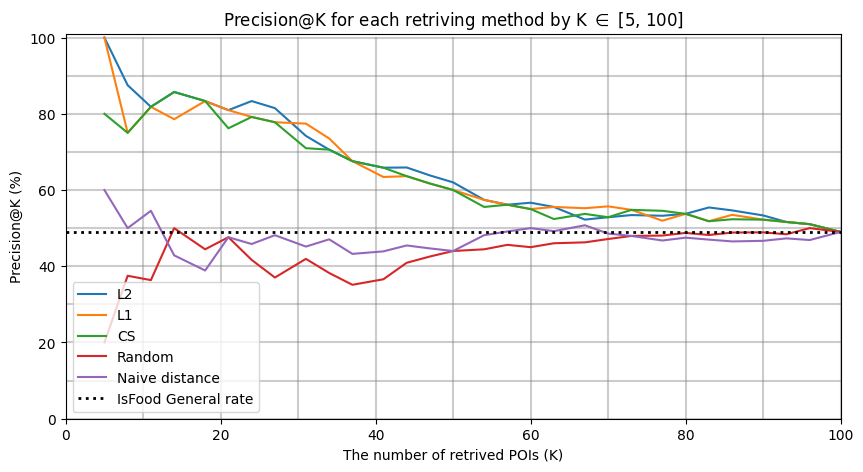

In [70]:
Ks = [int(n) for n in np.linspace(5, top_k, 30)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      eiffel_radius.sort_values(method).IsFood[:k].mean()
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100

# ##############################################################################

plt.figure(figsize=(10,5))
plt.title(f'Precision@K for each retriving method by K $\\in$ [5, {top_k}]')
for col in evaluation.columns:
    plt.plot(evaluation.index, evaluation[col], label=col if col!='distance_from_eiffel' else 'Naive distance')

plt.plot([0, top_k], [is_food_rate_eiffel, is_food_rate_eiffel],
         color='k', lw=2, linestyle='dotted', label = 'IsFood General rate')

for yi in np.linspace(0,100,11):
    plt.plot([0,top_k],[yi,yi], color='gray', alpha=.4, zorder=-1)

for xi in np.linspace(0,top_k,11):
    plt.plot([xi, xi],[0,100], color='gray', alpha=.4, zorder=-1)

plt.xlabel('The number of retrived POIs (K)')
plt.ylabel('Precision@K (%)')

plt.legend(loc='lower left')
plt.ylim(0,101)
plt.xlim(0,top_k)

plt.show()



In [82]:
higher_score_column = evaluation.idxmax(axis=1).value_counts().index[0]

print(f'The column with the higher score is {higher_score_column}')

The column with the higher score is L2


In [87]:
N_best_locations = 10

best_locations = eiffel_radius.sort_values(higher_score_column).iloc[:N_best_locations]
best_locations_xy = best_locations.geometry.to_crs(WGS84_GEO_DD).apply(lambda geometry: geometry if geometry.geom_type=='Point' else geometry.centroid)

fmap = folium.Map(location=[eiffel_y,eiffel_x], zoom_start=16, width=1500, height=500)

for location, name in zip(locations, eiffel_radius.name):
    folium.Marker([location.y ,location.x],
                  tooltip=name,
                  zIndexOffset=-1,
                  icon=folium.Icon(color='green', icon='flag')).add_to(fmap)

for location, name in zip(best_locations_xy, best_locations.name):
    folium.Marker([location.y ,location.x],
                  tooltip=name,
                  zIndexOffset=100,
                  icon=folium.Icon(color='red', icon='cutlery')).add_to(fmap)

folium.Marker([eiffel_y,eiffel_x],
              tooltip="Tour Eiffel",
              icon=folium.Icon(color='blue',
                               icon='star-empty'),
              zIndexOffset=200).add_to(fmap)

fmap

# Bon appétit!